In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
fontsize = 20
from functools import partial, reduce
# compose = lambda *F: reduce(lambda f, g: lambda x: f(g(x)), F)
from funcy import compose
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from scipy.signal import savgol_filter, periodogram
from scipy import interpolate
from scipy.integrate import trapz
from scipy.stats import wilcoxon, ranksums, mannwhitneyu, friedmanchisquare
from numpy.fft import fft, ifft, fftfreq
from time import time
from tqdm import tqdm

from tqdm import trange
from best_subset import *
from solvel0 import solvel0
from pde_diff_new import RPCA
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff
import pynumdiff
import pynumdiff.optimize
import sys; sys.path.insert(0, "../derivative/"); import derivative
from derivative import dxdt as ddd

from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.preprocessing import normalize as sk_normalize
from sklearn.utils.random import sample_without_replacement

from findiff import FinDiff
# from abess.linear import LinearRegression
from UBIC import fit_blr, UBIC, decreasing_values_indices
# from skscope_tools import best_subset_all_solutions, abess_all_solutions
from para_UBIC import *
from mdl_comp import RidgeMDLCOMP

from pysr import PySRRegressor

import seaborn as sns
from scipy.interpolate import make_interp_spline, BSpline

def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)

np.random.seed(1234)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.4.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.
Best-subset solvers are NOT installed.
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
def parametric_burgers_rhs(u, t, params):
    k,a,b,c = params
    deriv = a*(1+c*np.sin(t))*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u))
    return real(deriv)

# Set size of grid -> affect discovery results
n = 256
m = 256
    
# Set up grid
x = np.linspace(-8,8,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,10,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x+1)**2)

# Solve with time dependent uu_x term
params = (k, -1, 0.1, 0.25)
u = odeint(parametric_burgers_rhs, u0, t, args=(params,)).T # shape = (len(x), len(t))

u_xx_true = 0.1*np.ones(m)
uu_x_true = -1*(1+0.25*np.sin(t))

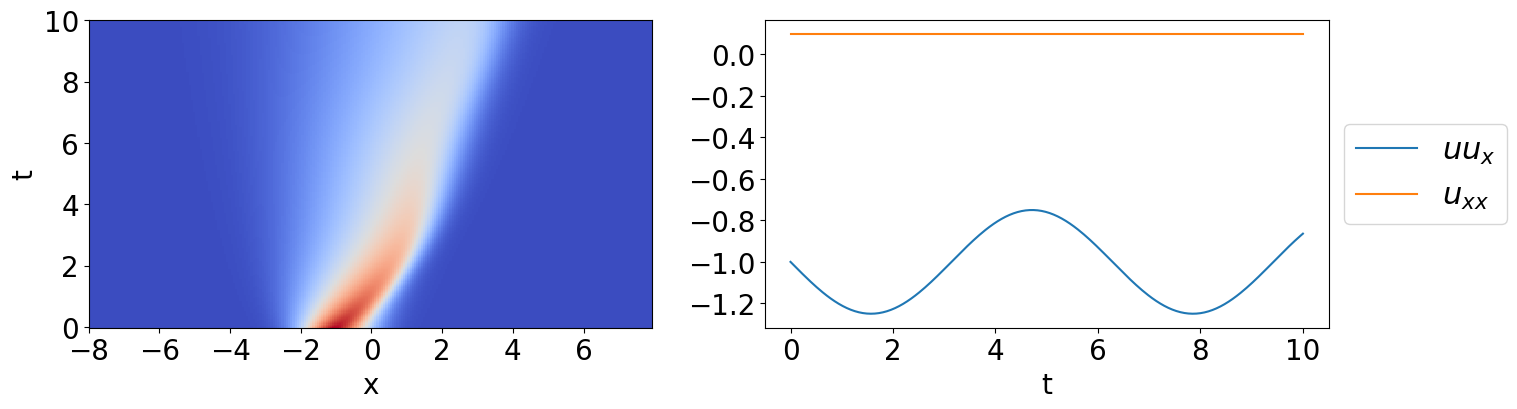

In [3]:
# Plot
fig=figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(t, uu_x_true, label=r'$uu_{x}$')
plot(t, u_xx_true, label=r'$u_{xx}$')

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('t', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [4]:
u_clean = u.copy()
u_clean_t = FinDiff(1, dt, 1, acc=4)(u_clean)
u_clean_x = FinDiff(0, dx, 1, acc=4)(u_clean)
u_clean_xx = FinDiff(0, dx, 1, acc=4)(u_clean_x)
u_clean_xxx = FinDiff(0, dx, 1, acc=4)(u_clean_xx)
u_clean_xxxx = FinDiff(0, dx, 1, acc=4)(u_clean_xxx)
noise_lv = 4 # 2, 4
noise_lv = abs(noise_lv)
u = u + 0.01*noise_lv*std(u)*np.random.randn(n, m)

In [5]:
include_bias = False
is_denoising = True

if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    u = savgol_filter(u, window_size, poly_order, axis=1)

ttt = u.copy()
alpha = 3e-4
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                              diff_kwargs, 
                                                                              include_bias=include_bias, 
                                                                              dependent='temporal')

# Theta_grouped, Ut_grouped = spatial_temporal_group(Theta, Ut, (n,m), "temporal")

# fs = (np.arange(len(t))/t)[1]

# f, P_clean = periodogram(u_clean_t, fs)
# fig=figure(figsize=(10,4))
# subplot(1,2,1)
# pcolor(*np.meshgrid(x, t), u_clean_t.T)
# xlabel('x', fontsize = fontsize)
# ylabel('t', fontsize = fontsize)
# subplot(1,2,2)
# pcolor(*np.meshgrid(x, f), P_clean.T, cmap=cm.coolwarm)
# xlabel('x', fontsize = fontsize)
# ylabel('f', fontsize = fontsize)
# plt.show()

# fig=figure(figsize=(10,4))
# subplot(1,2,1)
# Ut_rec = Ut.reshape(u.shape).T
# f, P = periodogram(Ut_rec, fs)
# pcolor(*np.meshgrid(x, t), Ut_rec.T)
# xlabel('x', fontsize = fontsize)
# ylabel('t', fontsize = fontsize)
# subplot(1,2,2)
# pcolor(*np.meshgrid(x, f), P.T, cmap=cm.coolwarm)
# xlabel('x', fontsize = fontsize)
# ylabel('f', fontsize = fontsize)
# plt.show()

In [6]:
fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(len(rhs_des))])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

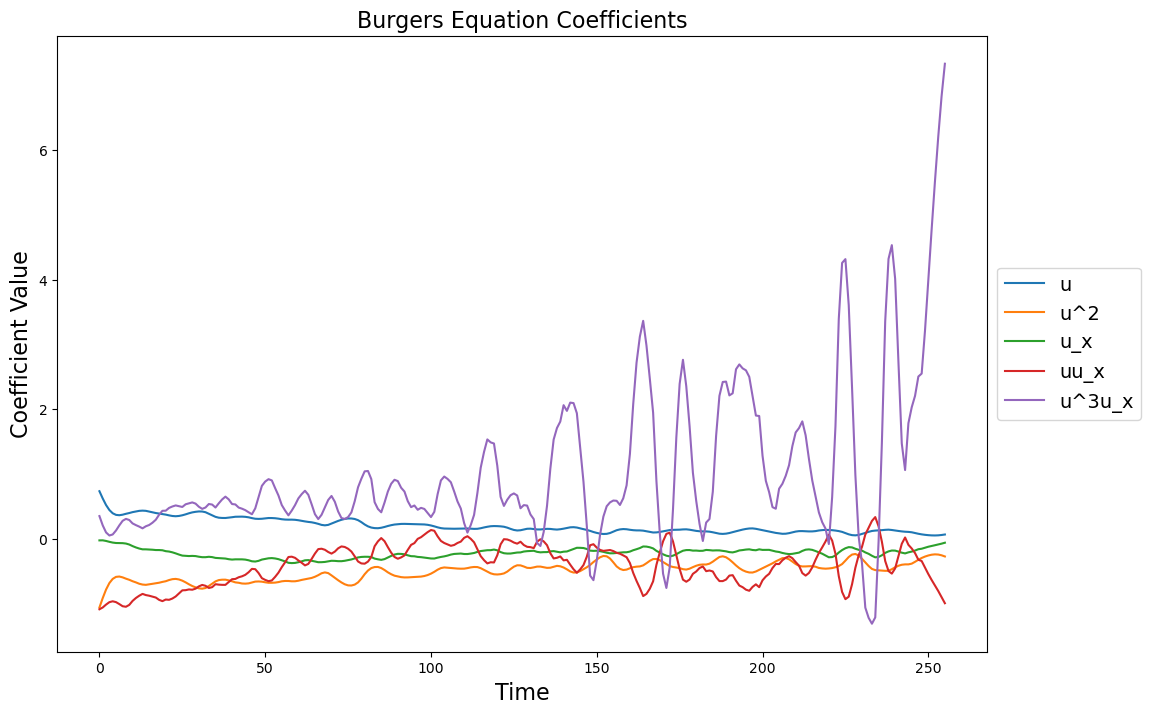

In [7]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped, normalize=2)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in np.where(np.linalg.norm(xi, axis=-1) > 1e-10)[0]:
    plot(xi[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
show()

In [8]:
# 0.1821324868907128
# xi = xi[np.where(np.linalg.norm(xi, axis=-1))[0]]
xi = xi[[4, 7]]
errors = np.array([coeff_error(xi[0], u_xx_true), coeff_error(xi[1], uu_x_true)])
print(errors)
errors.mean(), errors.std()

[100.          61.20097074]


(80.60048537091185, 19.399514629088138)

In [9]:
if noise_lv == 2:
    candidates = [(3,),
                  (4, 7),
                  (4, 7, 8),
                  (0, 2, 4, 7),
                  (1, 2, 4, 7, 15),
                  (0, 1, 2, 3, 4, 7),
                  (0, 1, 2, 3, 4, 7, 15),
                  (0, 1, 2, 3, 4, 5, 7, 11),
                  (0, 1, 2, 3, 4, 5, 7, 10, 11),
                  (0, 1, 2, 3, 4, 7, 10, 11, 15, 18)] 
elif noise_lv == 4:
    candidates = {(0, 1, 2, 3, 4, 6, 7),
                  (0, 1, 2, 3, 4, 7),
                  (0, 1, 2, 3, 5, 6, 7, 11, 15),
                  (0, 1, 2, 3, 5, 7, 11, 18),
                  (0, 1, 2, 3, 7, 10, 11, 15, 16, 17),
                  (0, 1, 3, 4, 7),
                  (1, 2, 4, 7),
                  (3,),
                  (4, 7),
                  (4, 7, 8)}
    
candidates = sorted(candidates, key=len)
rhs_des[4], rhs_des[7]

('u_xx', 'uu_x')

#### Bootstrap

In [10]:
lnorm = 1
n_models = 20
uncerts = [[] for _ in range(len(candidates))]
mean_coeffs = [[] for _ in range(len(candidates))]
std_coeffs = [[] for _ in range(len(candidates))]
for j in trange(len(candidates)):
    for i in range(len(Theta_grouped)):
        np.random.seed(i)
        coeffs = []
        for _ in range(n_models):
            sample_indices = np.random.choice(range(Theta_grouped[i].shape[0]), 
                                              size=int(Theta_grouped[i].shape[0]*0.8), 
                                              replace=True)
            coeffs.append(np.linalg.lstsq(Theta_grouped[i][sample_indices, :][:, candidates[j]], 
                                          Ut_grouped[i][sample_indices, :], rcond=None)[0])
        coeffs = np.hstack(coeffs)
        mean_coeff = coeffs.mean(axis=1)
        std_coeff = coeffs.std(axis=1)
        total_std = np.sum(std_coeff)
        
        if lnorm > 0: uncert = total_std/np.linalg.norm(mean_coeff, lnorm)
        else: uncert = total_std
            
        uncerts[j].append(uncert)
        mean_coeffs[j].append(mean_coeff)
        std_coeffs[j].append(std_coeff)
        
cvs = np.sum(uncerts, axis=1)
cvs = cvs/min(cvs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.00it/s]


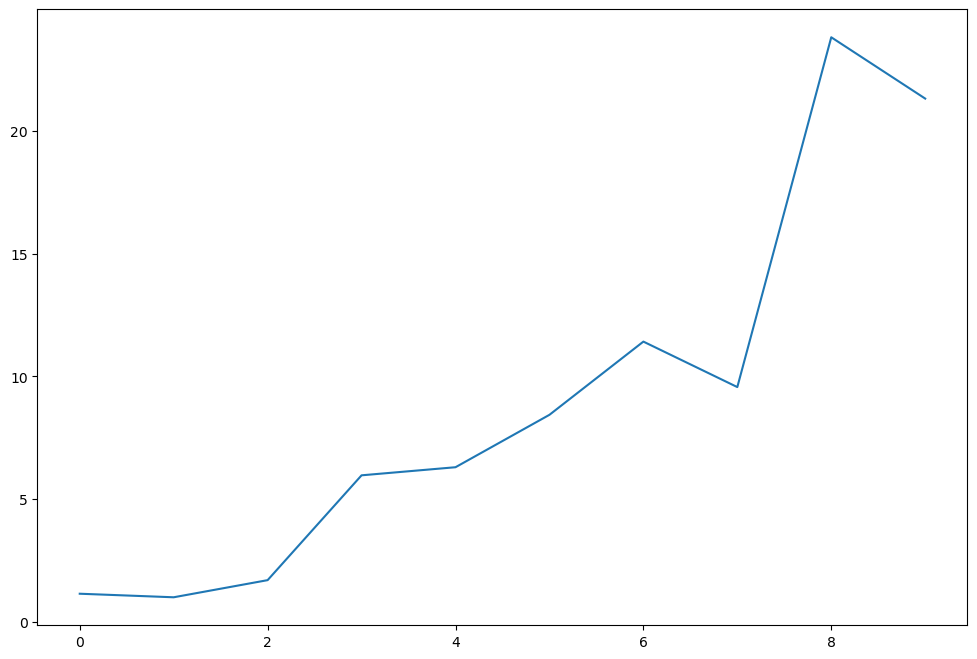

In [11]:
plt.plot(cvs)

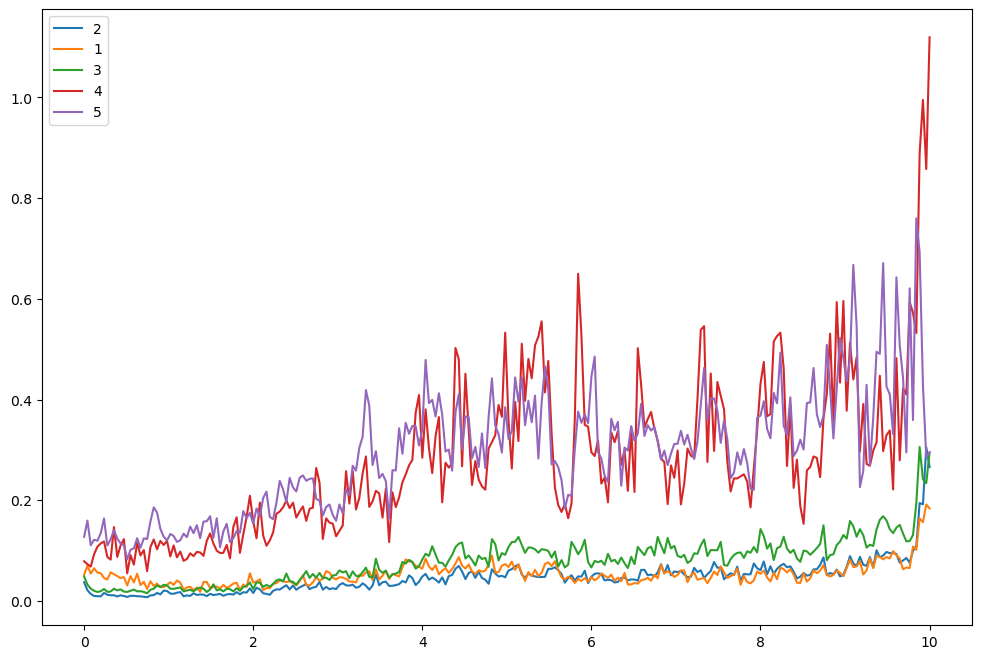

In [12]:
for i in np.argsort(cvs)[:5]:
    plt.plot(t, uncerts[i], label=f'{str(i+1)}')
plt.legend()

<ErrorbarContainer object of 3 artists>

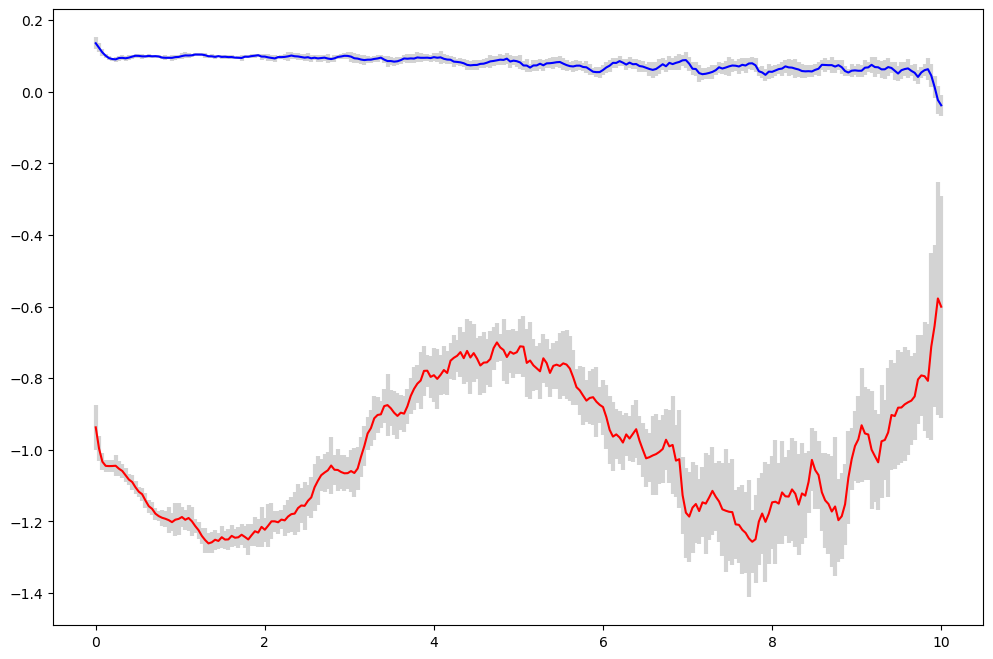

In [13]:
plt.errorbar(t, np.array(mean_coeffs[1])[:,0], yerr=2*np.array(std_coeffs[1])[:,0], 
             fmt='-', color='blue', ecolor='lightgray', elinewidth=3, capsize=0)
plt.errorbar(t, np.array(mean_coeffs[1])[:,1], yerr=2*np.array(std_coeffs[1])[:,1], 
             fmt='-', color='red', ecolor='lightgray', elinewidth=3, capsize=0)

#### ARDRegression

In [14]:
ard_uncerts = [[] for _ in range(len(candidates))]
ard_mean_coeffs = [[] for _ in range(len(candidates))]
ard_std_coeffs = [[] for _ in range(len(candidates))]
for i, indices in enumerate(candidates):
    for j in range(0, len(Theta_grouped), 1):        
        # model = BayesianRidge(fit_intercept=False)
        model = ARDRegression(threshold_lambda=2*1e4, fit_intercept=False)
        model.fit(Theta_grouped[j][:, indices], Ut_grouped[j].flatten())
        
        coeff = model.coef_
        std_coeff = np.sqrt(np.diag(model.sigma_))
        ard_uncerts[i].append(std_coeff.sum()/np.linalg.norm(coeff, lnorm))
        ard_mean_coeffs[i].append(coeff)
        ard_std_coeffs[i].append(std_coeff)
        
ard_cvs = np.array(ard_uncerts).sum(axis=1)
ard_cvs /= min(ard_cvs)
# ard_cvs

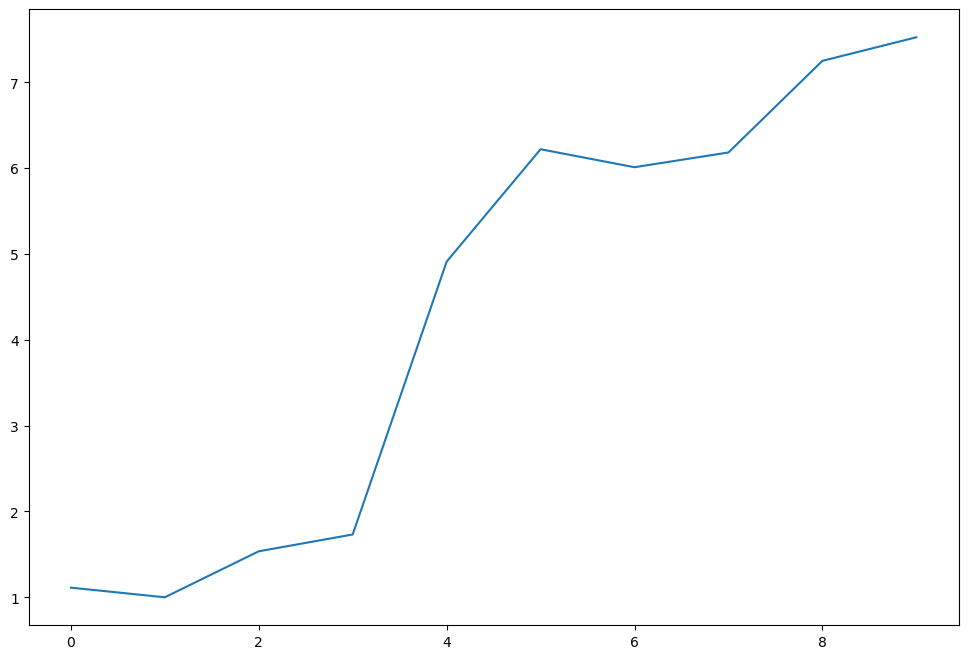

In [15]:
plt.plot(ard_cvs)

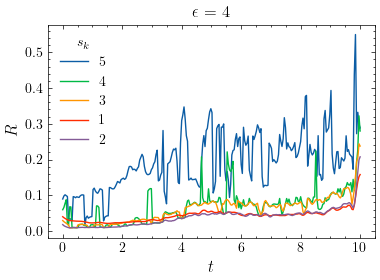

In [16]:
fs = 12
with plt.style.context('science'):
    fig, ax = plt.subplots(figsize=(4, 3))
    for i in np.argsort(ard_cvs)[:5][::-1]:
        ax.plot(t, ard_uncerts[i], label=f'{str(i+1)}')
    ax.set_ylabel("$R$", fontsize=fs)
    ax.set_xlabel("$t$", fontsize=fs)
    ax.set_title(f"$\epsilon$ = {noise_lv}", fontsize=fs)
    ax.legend(title="$s_{k}$")
    fig.tight_layout()
    # plt.savefig(f"/Users/pongpisit/Documents/latex/UBIC-ACML/figures/burgers_r_noise{noise_lv}.pdf")
    plt.show()

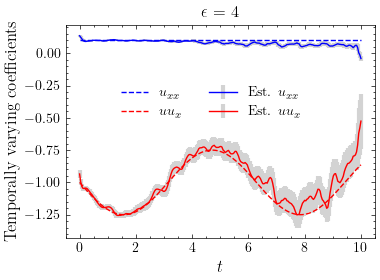

In [17]:
with plt.style.context('science'):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.errorbar(t, np.array(ard_mean_coeffs[1])[:,0], yerr=2*np.array(ard_std_coeffs[1])[:,0], 
                 fmt='-', color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label="Est. $u_{xx}$")
    ax.errorbar(t, np.array(ard_mean_coeffs[1])[:,1], yerr=2*np.array(ard_std_coeffs[1])[:,1], 
                 fmt='-', color='red', ecolor='lightgray', elinewidth=3, capsize=0, label="Est. $uu_{x}$")
    ax.plot(t, u_xx_true, '--', color='blue', label="$u_{xx}$")
    ax.plot(t, uu_x_true, '--', color='red', label="$uu_{x}$")
    ax.set_xlabel("$t$", fontsize=fs)
    ax.set_ylabel('Temporally varying coefficients', fontsize=fs)
    ax.set_title(f"$\epsilon$ = {noise_lv}", fontsize=fs)
    ax.legend(ncol=2, bbox_to_anchor=(0.8, 0.5))
    fig.tight_layout()
    plt.savefig(f"/Users/pongpisit/Documents/latex/UBIC-ACML/figures/burgers_ci_noise{noise_lv}.pdf")
    plt.show()

In [18]:
f_u_xx, f_uu_x = linear_fit_grouped_data((Theta_grouped, Ut_grouped), considered_indices=candidates[1])

#### PySR, epsilon = 2

In [19]:
model = PySRRegressor(
    niterations=100,  
    binary_operators=["+", "-", "*"],
    unary_operators=[
        "cos",
        "sin"
    ],
)
model.fit(t.reshape(-1,1), f_uu_x.reshape(-1,1))

Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 2.730e+05
Head worker occupation: 25.0%
Progress: 599 / 1500 total iterations (39.933%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           2.938e-02  7.971e+00  y = sin(-1.5708)
3           2.835e-02  3.565e-02  y = -0.51604 + -0.51604
5           2.778e-02  1.015e-02  y = -1.0733 + (0.0082349 * x₀)
6           5.323e-04  3.955e+00  y = -0.98643 + (-0.25067 * sin(x₀))
7           5.298e-04  4.709e-03  y = sin(-0.25269 * sin(x₀)) + -0.98641
8           5.000e-04  5.777e-02  y = -0.98744 + (sin(x₀ * 1.0053) * -0.25061)
9           4.995e-04  1.078e-03  y = -0.98744 + sin(sin(x₀ * 1.0053) * -0.25061)
11          3.635e-04  1.589e-01  y = ((-0.25066 * sin(x₀)) - cos(-0.030331 * x₀)) - 0.0017081
12          3.615e-04  5.742e-03  y = (sin(-0.25309 * sin(x₀)) - cos(-0.029407 * x₀)) - 0.000661...
                                  02
14         

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          -0.834786   
	1         0.828470                                    sin(-1.5707679)   
	2         0.035648                          -0.51603836 + -0.51603836   
	3         0.010148                    -1.0732502 + (0.008234938 * x0)   
	4         3.954956                -0.9864293 + (-0.2506664 * sin(x0))   
	5         0.004709             sin(-0.2526899 * sin(x0)) + -0.9864081   
	6         0.057768  -0.98744345 + (0.25060657 * sin(x0 * -1.0052764))   
	7         0.004749  -0.98742896 + sin(sin(x0 * 1.005255) * -0.2526...   
	8         0.000279  -0.98742896 + sin(sin(sin(x0 * 1.005255) * -0....   
	9   >>>>  0.314650  ((-0.25131866 * sin(x0)) - cos(x0 * 0.02889932...   
	10        0.004885  (sin(-0.25309324 * sin(x0)) - cos(-0.029407086...   
	11        0.019868  ((sin(x0) * -0.25309324) - cos(-0.03670406 * (...   
	12        0.003024  (sin(sin(x0) * -0.25309324) - cos(-0.03670406 ...   
	13        0.008028  ((sin(x0) * -0.25309324) - cos(-0.03670406 * (...   
	14        0.000020  ((sin(x0) * -0.25309324) - cos(sin(-0.03670406...   
	15        0.020979  ((-0.25066492 * sin(x0)) - cos(-0.030331187 * ...   
	16        0.009227  (sin(-0.25066492 * sin(x0)) - cos(-0.030331187...   
	17        0.000323  (sin(-0.25066492 * sin(x0)) - cos(-0.030331187...   
	
	        loss  complexity  
	0   0.067274           1  
	1   0.029380           2  
	2   0.028351           3  
	3   0.027781           5  
	4   0.000532           6  
	5   0.000530           7  
	6   0.000500           8  
	7   0.000498           9  
	8   0.000498          10  
	9   0.000363          11  
	10  0.000361          12  
	11  0.000354          13  
	12  0.000353          14  
	13  0.000350          15  
	14  0.000350          16  
	15  0.000343          17  
	16  0.000340          18  
	17  0.000340          20  
]

In [20]:
model = PySRRegressor(
    niterations=100,  
    binary_operators=["+", "-", "*"],
    unary_operators=[
        "cos",
        "sin"
    ],
)
model.fit(t.reshape(-1,1), f_u_xx.reshape(-1,1))

[ Info: Started!



Expressions evaluated per second: 3.880e+05
Head worker occupation: 33.8%
Progress: 807 / 1500 total iterations (53.800%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           3.250e+01  1.594e+01  y = x₀
2           8.447e-05  1.282e+01  y = sin(0.09455)
5           4.222e-05  2.312e-01  y = (-0.0022543 * x₀) - -0.10569
6           4.222e-05  9.662e-05  y = sin((x₀ * -0.0022481) - -0.10579)
7           4.204e-05  4.144e-03  y = sin(cos(x₀ * -0.020523) - 0.89858)
9           4.199e-05  6.457e-04  y = sin(sin(cos(x₀ * -0.027866)) - sin(0.8329))
10          4.198e-05  2.107e-04  y = sin(sin(cos(sin(-0.028334 * x₀))) - sin(0.83282))
11          4.002e-05  4.775e-02  y = sin(cos(-0.020523 * (x₀ - sin(sin(x₀)))) - 0.89858)
12          3.983e-05  4.715e-03  y = sin(sin(cos((x₀ - sin(x₀)) * -0.028334)) - sin(0.83282))
13          3.961e-05  5.494e-03  y = sin(sin(cos(-0.028334 * 

PySRRegressor.equations_ = [
	    pick      score                                           equation  \
	0          0.000000                                                 x0   
	1         12.860387                                    sin(0.09454971)   
	2   >>>>   0.231172                (-0.0022542933 * x0) - -0.105685525   
	3          0.000097            sin((x0 * -0.0022480618) - -0.10578529)   
	4          0.006226            sin(cos(-0.066725634 * x0) * 0.1020837)   
	5          0.000290       sin(sin(0.1020837 * cos(x0 * -0.066725634)))   
	6          0.000206  sin(cos((x0 + 0.23718834) * -0.020231484) - 0....   
	7          0.040942  sin(cos(-0.020523472 * (x0 - sin(x0))) - 0.898...   
	8          0.005729  sin(cos(-0.020523472 * (x0 - sin(sin(x0)))) - ...   
	9          0.004715  sin(sin(cos((x0 - sin(x0)) * -0.028333543)) - ...   
	10         0.028424  sin(cos((sin(x0 - sin(x0)) - x0) * -0.02052347...   
	11         0.008747  sin(cos((sin((x0 + -0.50557786) - sin(x0)) - x...   
	12         0.011445  sin(cos((cos(((cos(x0) - x0) * -0.32002136) * ...   
	
	         loss  complexity  
	0   32.501293           1  
	1    0.000084           2  
	2    0.000042           5  
	3    0.000042           6  
	4    0.000042           7  
	5    0.000042           8  
	6    0.000042           9  
	7    0.000040          10  
	8    0.000040          11  
	9    0.000040          12  
	10   0.000039          13  
	11   0.000038          15  
	12   0.000037          17  
]

In [21]:
y1 = -0.9864293 + (-0.2506664*sin(t))
y2 = sin(0.09454971)*np.ones(len(t))
coeff_error(y1, uu_x_true), coeff_error(y2, u_xx_true)

(1.2863717170852231, 5.591100561064209)

#### PySR, epsilon = 4

In [11]:
model = PySRRegressor(
    niterations=100,  
    binary_operators=["+", "-", "*"],
    unary_operators=[
        "cos",
        "sin"
    ],
)

In [12]:
model.fit(t.reshape(-1,1), f_uu_x.reshape(-1,1))

Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 3.170e+05
Head worker occupation: 24.9%
Progress: 694 / 1500 total iterations (46.267%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           9.035e-02  1.594e+01  y = -1.2501
2           3.061e-02  1.082e+00  y = sin(-1.5706)
3           3.058e-02  1.048e-03  y = -1.5892 + 0.58357
5           2.857e-02  3.399e-02  y = -1.083 - (x₀ * -0.01547)
6           2.584e-03  2.403e+00  y = -0.95987 - (sin(x₀) * 0.25146)
7           2.538e-03  1.827e-02  y = -0.95964 + (-0.28536 * sin(sin(x₀)))
8           2.415e-03  4.962e-02  y = -0.96224 - (sin(x₀ * -1.0122) * -0.25162)
9           2.378e-03  1.520e-02  y = -0.96201 - (sin(sin(x₀ * 1.0115)) * 0.2853)
10          1.510e-03  4.541e-01  y = ((x₀ * 0.011332) + -1.0172) - (sin(x₀) * 0.24986)
11          1.505e-03  3.218e-03  y = (-1.0172 + (x₀ * 0.011332)) - sin(sin(x₀) * 0.24986)
12          1.385e-0

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         -1.1837214   
	1         0.710313                                     sin(-1.570617)   
	2         0.001048                             -1.5892271 + 0.5835671   
	3         0.033995                   -1.0830156 - (x0 * -0.015470395)   
	4         2.402847                -0.95987153 - (sin(x0) * 0.2514625)   
	5         0.018271          -0.9596376 + (-0.28535593 * sin(sin(x0)))   
	6         0.049619  -0.9622427 - (sin(x0 * -1.0122207) * -0.25161898)   
	7         0.015203  -0.96200824 - (sin(sin(x0 * 1.0114661)) * 0.28...   
	8   >>>>  0.455335  ((x0 * 0.011347105) + -1.0172554) - (0.2478888...   
	9         0.002001  (-1.0171574 + (x0 * 0.01133149)) - sin(0.24986...   
	10        0.083881  (((x0 * x0) * 0.001168421) + -0.9984349) - (0....   
	11        0.001193  (-0.9984348 + (x0 * (0.0011459506 * x0))) - si...   
	12        0.009281  ((((0.001829751 * x0) + -0.007112878) * x0) + ...   
	13        0.004660  ((((0.001829751 * x0) + -0.007112878) * x0) + ...   
	14        0.017982  (-1.0149777 + ((cos(cos(x0 * -2.0958183)) * 0....   
	15        0.013143  ((0.0011459506 * ((x0 + sin(x0 * -1.6419201)) ...   
	16        0.001775  ((x0 * (0.016201524 * cos(sin((0.9665896 - x0)...   
	17        0.026397  ((0.0011459506 * ((x0 + sin(x0 * (-1.6419201 -...   
	18        0.014168  ((0.0011459506 * ((x0 + sin((sin(x0) * x0) * -...   
	
	        loss  complexity  
	0   0.062285           1  
	1   0.030613           2  
	2   0.030580           3  
	3   0.028570           5  
	4   0.002584           6  
	5   0.002538           7  
	6   0.002415           8  
	7   0.002378           9  
	8   0.001508          10  
	9   0.001505          11  
	10  0.001384          12  
	11  0.001383          13  
	12  0.001370          14  
	13  0.001364          15  
	14  0.001339          16  
	15  0.001322          17  
	16  0.001319          18  
	17  0.001285          19  
	18  0.001267          20  
]

In [13]:
model.fit(t.reshape(-1,1), f_u_xx.reshape(-1,1))

[ Info: Started!



Expressions evaluated per second: 3.950e+05
Head worker occupation: 19.6%
Progress: 865 / 1500 total iterations (57.667%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           3.269e+01  1.594e+01  y = x₀
2           3.659e-04  1.139e+01  y = sin(0.080886)
5           3.039e-04  6.190e-02  y = 0.080886 + (-0.0015224 * x₀)
6           1.204e-04  9.263e-01  y = cos(0.10755 * x₀) * 0.099035
7           1.203e-04  3.046e-04  y = cos(0.10755 * x₀) * sin(0.099035)
8           1.192e-04  9.681e-03  y = 0.099431 * cos(0.099431 * (x₀ - -0.69339))
9           1.145e-04  3.979e-02  y = cos(0.11234 * (x₀ - sin(x₀))) * 0.099035
10          1.129e-04  1.407e-02  y = cos(0.11234 * (x₀ - sin(sin(x₀)))) * 0.099035
11          1.062e-04  6.085e-02  y = cos(0.11234 * (x₀ - sin(x₀ - 0.59611))) * 0.099035
12          1.057e-04  5.472e-03  y = sin(0.10022 * cos((x₀ - sin(-2.4807 - x₀)) * 0.1130

PySRRegressor.equations_ = [
	    pick      score                                           equation  \
	0          0.000000                                                 x0   
	1         11.400078                                   sin(0.080886364)   
	2   >>>>   0.324982                  (-0.0039760876 * x0) + 0.10061145   
	3          0.137072                  cos(0.10755047 * x0) * 0.09903513   
	4          0.000305             cos(0.10755047 * x0) * sin(0.09903513)   
	5          0.009681   0.09943104 * cos(0.09943104 * (x0 - -0.6933935))   
	6          0.039793      cos(0.11233577 * (x0 - sin(x0))) * 0.09903513   
	7          0.014072  cos(0.11233577 * (x0 - sin(sin(x0)))) * 0.0990...   
	8          0.060847  cos(0.11233577 * (x0 - sin(x0 - 0.59610665))) ...   
	9          0.005488  sin(0.10022325 * cos(0.113092065 * (x0 - sin(-...   
	10         0.000341  sin(0.10022325 * cos(0.113092065 * (x0 - sin(s...   
	11         0.008481  sin(0.10022325 * cos((x0 - sin(x0 - cos(cos(x0...   
	12         0.033347  sin(0.10022325 * cos(0.113092065 * (x0 - sin((...   
	13         0.029787  sin(sin(cos(0.11698767 * (x0 + cos((x0 + 0.800...   
	
	         loss  complexity  
	0   32.688313           1  
	1    0.000366           2  
	2    0.000138           5  
	3    0.000120           6  
	4    0.000120           7  
	5    0.000119           8  
	6    0.000115           9  
	7    0.000113          10  
	8    0.000106          11  
	9    0.000106          12  
	10   0.000106          13  
	11   0.000105          14  
	12   0.000101          15  
	13   0.000098          16  
]

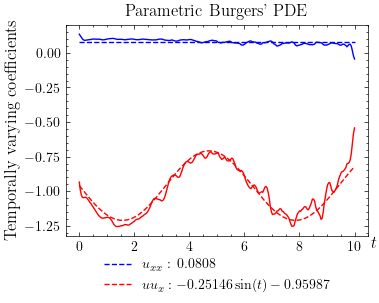

In [19]:
y1 = -0.9598714 + (sin(t) * -0.2514623)
y2 = sin(0.080887355)*np.ones(len(t))
fs = 12
with plt.style.context('science'):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(t, f_u_xx, '-', c='blue')
    ax.plot(t, y2, '--', c='blue', label='$u_{xx}:\, 0.0808$')
    ax.plot(t, f_uu_x, '-', c='red')
    ax.plot(t, y1, '--', c='red', label='$uu_{x}: -0.25146\sin(t)-0.95987$')
    ax.set_ylabel('Temporally varying coefficients', fontsize=fs)
    ax.set_xlabel('$t$', fontsize=fs)
    ax.xaxis.set_label_coords(1.02, 0)
    ax.set_title("Parametric Burgers' PDE", fontsize=fs)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=False, shadow=False, ncol=1)
    fig.tight_layout()
    # plt.savefig(f"/Users/pongpisit/Documents/latex/UBIC-ACML/figures/burgers_vc_noise{noise_lv}.pdf")
    plt.show()

In [20]:
y1 = -0.9598714 + (sin(t) * -0.2514623)
y2 = sin(0.080887355)*np.ones(len(t))
coeff_error(y1, uu_x_true), coeff_error(y2, u_xx_true)

(3.81265727448992, 19.200820631177947)